# Estimasi Harga Wajar Kos - Area Jakarta Pusat

**Objective:**  
Membangun model machine learning yang mampu mengestimasi harga wajar kosan di Jakarta Pusat dengan akurasi, stabilitas baik, dan siap untuk deployment production.

**Target Users:**  
Mahasiswa BCA yang ingin menghindari *overpricing* saat memilih kos, dan property owners yang ingin menentukan harga kompetitif.

**Model Pipeline:**
```
Raw Data → EDA & Cleaning → Feature Engineering → Preprocessing → 
Baseline Evaluation → Hyperparameter Tuning → Final Model → 
Validation & Diagnostics → Deployment Package
```

In [4]:
# IMPORTS & CONFIGURATION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from datetime import datetime

# Scikit-learn components
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Visualization & Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

---

## SECTION 1: Data Loading & Initial Exploration

Pada tahap awal, dataset Jakarta Pusat dimuat untuk memastikan struktur data sesuai dengan kebutuhan pemodelan. Pemeriksaan awal dilakukan untuk memahami ukuran dataset, melihat contoh data, serta memverifikasi keberadaan dan tipe data variabel target (harga).

Validasi ini penting untuk memastikan bahwa:

* Dataset berhasil dimuat tanpa kehilangan kolom penting.

* Jumlah baris dan kolom sesuai dengan ekspektasi.

* Variabel target tersedia sehingga dapat digunakan dalam tugas regresi.

In [5]:
df = pd.read_csv('../datasets/jakarta_pusat.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")

display(df.head())

assert 'harga' in df.columns, "Target column 'harga' not found"
assert df['harga'].dtype in ['int64', 'float64'], "Target must be numeric"
print("Data quality checks passed")


Dataset Shape: (500, 13)
Rows: 500 | Columns: 13


,nama_kos,harga,luas_kamar,jarak_ke_bca,tipe_kos,is_ac,is_km_dalam,is_water_heater,is_furnished,is_internet,is_listrik_free,is_parkir_mobil,is_mesin_cuci
0,Kost Cikini Cozy Coliving Exclusive Hoek Mente...,4500000,12.00,2.22,campur,1,1,1,1,1,0,1,1
1,Kost Singgahsini Cut Nyak Dien Residence Tipe ...,3025000,12.00,1.50,campur,1,1,1,1,1,1,1,1
2,Kost Singgahsini Shankee Sudirman Tipe B Setia...,4525000,15.00,1.84,campur,1,1,1,1,1,1,1,0
3,Kost Apik Perintis 5 Karet Kuningan Tipe D Set...,1155000,6.00,1.86,campur,1,0,0,1,1,0,1,0
4,Kost Singgahsini Kramat Kwitang 30 Tipe B Sene...,1495000,4.62,2.27,putra,1,0,0,1,1,1,0,0


Data quality checks passed


### Analisis Struktur Data

Dataset telah dimuat dengan sukses. Visualisasi 5 baris pertama menunjukkan kolom-kolom yang tersedia

In [6]:
# Informasi detail tentang tipe data dan missing values
df.info()

missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values detected")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nama_kos         500 non-null    object 
 1   harga            500 non-null    int64  
 2   luas_kamar       500 non-null    float64
 3   jarak_ke_bca     500 non-null    float64
 4   tipe_kos         500 non-null    object 
 5   is_ac            500 non-null    int64  
 6   is_km_dalam      500 non-null    int64  
 7   is_water_heater  500 non-null    int64  
 8   is_furnished     500 non-null    int64  
 9   is_internet      500 non-null    int64  
 10  is_listrik_free  500 non-null    int64  
 11  is_parkir_mobil  500 non-null    int64  
 12  is_mesin_cuci    500 non-null    int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 50.9+ KB
No missing values detected


Dataset Overview & Data Quality Assessment

Dataset Jakarta Pusat terdiri dari 500 entri dan 13 kolom, dengan seluruh kolom memiliki nilai lengkap tanpa data yang hilang. Struktur data menunjukkan kombinasi fitur numerik kontinu (seperti luas_kamar dan jarak_ke_bca), fitur kategorikal (nama_kos, tipe_kos), serta fitur biner yang merepresentasikan fasilitas kos.

In [7]:
# Statistik deskriptif untuk semua kolom numeric
print(df.describe().T)

print(f"Min: Rp {df['harga'].min():,.0f}")
print(f"Max: Rp {df['harga'].max():,.0f}")
print(f"Mean: Rp {df['harga'].mean():,.0f}")
print(f"Median: Rp {df['harga'].median():,.0f}")
print(f"Std Dev: Rp {df['harga'].std():,.0f}")
print(f"Skewness: {df['harga'].skew():.3f}")
print(f"Kurtosis: {df['harga'].kurtosis():.3f}")

                 count       mean        std       min        25%        50%  \
harga           500.00 2540182.58 1600448.20 550000.00 1498750.00 2000000.00   
luas_kamar      500.00      11.83       8.33      0.00       9.00      11.04   
jarak_ke_bca    500.00       1.72       0.60      0.47       1.26       1.89   
is_ac           500.00       1.00       0.00      1.00       1.00       1.00   
is_km_dalam     500.00       0.64       0.48      0.00       0.00       1.00   
is_water_heater 500.00       0.32       0.47      0.00       0.00       0.00   
is_furnished    500.00       0.92       0.27      0.00       1.00       1.00   
is_internet     500.00       1.00       0.00      1.00       1.00       1.00   
is_listrik_free 500.00       0.49       0.50      0.00       0.00       0.00   
is_parkir_mobil 500.00       0.31       0.46      0.00       0.00       0.00   
is_mesin_cuci   500.00       0.40       0.49      0.00       0.00       0.00   

                       75%         max 

Analisis statistik deskriptif menunjukkan bahwa harga kos di Jakarta Pusat memiliki rentang yang cukup lebar, dengan nilai minimum sebesar Rp 550.000 dan maksimum mencapai Rp 15.000.000. Nilai median berada pada Rp 2.000.000, sementara rata-rata harga lebih tinggi (Rp 2.540.183), mengindikasikan adanya skewness positif pada distribusi harga.

Distribusi target harga memiliki skewness sebesar 1.877 dan kurtosis sebesar 7.378, yang menunjukkan distribusi condong ke kanan dengan ekor berat (heavy-tailed). Hal ini mengindikasikan keberadaan properti dengan harga tinggi yang berpotensi memengaruhi proses pelatihan model, terutama pada model yang sensitif terhadap outlier.

Fitur luas_kamar menunjukkan variasi yang cukup signifikan, dengan median sekitar 11 m² namun nilai maksimum mencapai 126 m², yang menandakan adanya unit berukuran tidak umum. Variabel jarak (jarak_ke_bca) relatif terdistribusi sempit dengan nilai median 1.89 km, mencerminkan karakteristik wilayah pusat kota yang padat.

Sebagian besar fitur fasilitas bersifat biner dan memiliki distribusi tidak seimbang, seperti is_ac dan is_internet yang bernilai 1 pada seluruh data, serta is_furnished yang mendominasi dataset. Kondisi ini perlu diperhatikan pada tahap feature selection karena fitur dengan variansi sangat rendah cenderung memberikan kontribusi terbatas pada model.

Secara keseluruhan, hasil ini menunjukkan bahwa dataset siap digunakan untuk pemodelan, namun karakteristik distribusi harga dan keberadaan nilai ekstrem perlu dipertimbangkan pada tahap preprocessing dan evaluasi model agar tidak terjadi bias prediksi.

---

## SECTION 2: Exploratory Data Analysis (EDA) & Outlier Detection

**Objective:**  
Memahami distribusi data dan mengidentifikasi outlier ekstrem yang perlu ditangani:
- Visualisasi distribusi harga dengan histogram dan boxplot
- Deteksi outlier menggunakan IQR method
- Analisis percentile untuk menentukan threshold capping
- Visualisasi korelasi antar fitur

**Why This Matters:**
- Outlier ekstrem bisa mencerita model regresi, terutama linear models
- Kos dengan harga yang sangat jarang dan tidak relevan target market
- Kita perlu fokus pada mayoritas data (kos standar) untuk akurasi lebih baik

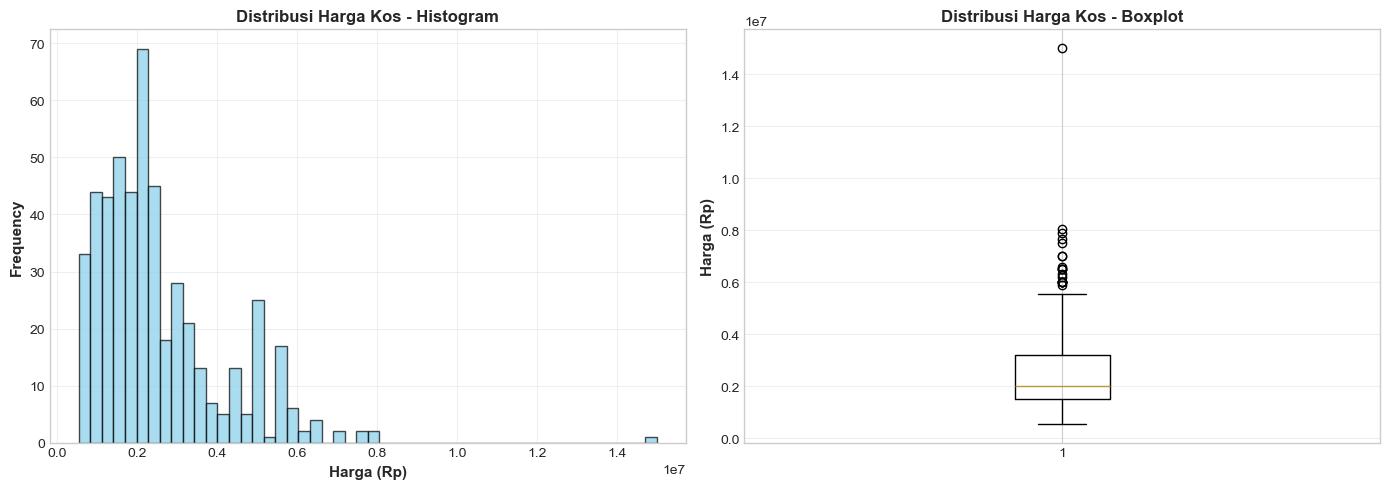

In [8]:
# Visualisasi distribusi awal harga
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['harga'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Distribusi Harga Kos - Histogram', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Boxplot untuk melihat outlier
axes[1].boxplot(df['harga'], vert=True)
axes[1].set_ylabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[1].set_title('Distribusi Harga Kos - Boxplot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Distribusi harga kos di Jakarta Pusat menunjukkan pola right-skewed, di mana sebagian besar data terkonsentrasi pada rentang harga menengah ke bawah, sementara terdapat sejumlah unit dengan harga jauh lebih tinggi. Hal ini terlihat jelas dari histogram yang memiliki ekor panjang di sisi kanan serta boxplot yang menampilkan banyak outlier di atas batas atas distribusi.

Keberadaan outlier mencerminkan heterogenitas pasar kos di Jakarta Pusat dan tidak langsung dianggap sebagai noise. Namun, pola ini memiliki implikasi terhadap pemodelan, terutama pada model yang sensitif terhadap nilai ekstrem. Oleh karena itu, analisis performa model akan mempertimbangkan metrik yang lebih robust terhadap outlier serta evaluasi berdasarkan segmen harga.

In [9]:
# analisis outlier menggunakan IQR dan percentile

Q1 = df['harga'].quantile(0.25)
Q3 = df['harga'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nIQR Method:")
print(f"Q1 (25th percentile): Rp {Q1:,.0f}")
print(f"Q3 (75th percentile): Rp {Q3:,.0f}")
print(f"IQR: Rp {IQR:,.0f}")
print(f"Lower Bound: Rp {lower_bound:,.0f}")
print(f"Upper Bound: Rp {upper_bound:,.0f}")

outliers_iqr = df[(df['harga'] < lower_bound) | (df['harga'] > upper_bound)]
print(f"\n  Outliers detected (IQR): {len(outliers_iqr)} ({len(outliers_iqr)/len(df)*100:.1f}%)")

print("\nPercentile Analysis:")
for pct in [90, 95, 99]:
    val = df['harga'].quantile(pct/100)
    print(f"  {pct}th percentile: Rp {val:,.0f}")

cap_limit = df['harga'].quantile(0.99)
print(f"\nCapping akan diterapkan di 99th percentile: Rp {cap_limit:,.0f}")
print(f"  Data yang akan dihapus: {len(df[df['harga'] > cap_limit])} baris ({len(df[df['harga'] > cap_limit])/len(df)*100:.1f}%)")


IQR Method:
Q1 (25th percentile): Rp 1,498,750
Q3 (75th percentile): Rp 3,200,000
IQR: Rp 1,701,250
Lower Bound: Rp -1,053,125
Upper Bound: Rp 5,751,875

  Outliers detected (IQR): 19 (3.8%)

Percentile Analysis:
  90th percentile: Rp 5,000,000
  95th percentile: Rp 5,500,000
  99th percentile: Rp 7,005,000

Capping akan diterapkan di 99th percentile: Rp 7,005,000
  Data yang akan dihapus: 5 baris (1.0%)


Berdasarkan metode IQR, teridentifikasi 19 data (3.8%) sebagai outlier dengan batas atas sebesar Rp 5.751.875. Namun, analisis persentil menunjukkan bahwa harga hingga 99th percentile (Rp 7.005.000) masih merepresentasikan bagian valid dari pasar kos Jakarta Pusat.

Untuk menjaga keseimbangan antara representasi pasar dan stabilitas model, outlier ekstrem di atas 99th percentile akan dihapus, yang berdampak pada penghapusan 5 baris data (1.0%). Pendekatan ini dipilih agar model tidak terlalu dipengaruhi oleh harga ekstrem, tanpa menghilangkan karakteristik utama distribusi harga.

---

## SECTION 3: Data Cleaning & Preprocessing

**Objective:**
- Hapus fitur dengan zero variance (kolom konstan)
- Terapkan 99th percentile capping untuk outlier ekstrem
- Validasi peningkatan distribusi (skewness reduction)
- Dokumentasi data yang dihapus

**Rationale:**
- **Zero Variance**: Fitur yang nilai-nya identik untuk semua baris tidak memberikan discriminant power
- **Percentile Capping**: Membuang top 1% (outlier ekstrem) untuk normalisasi distribusi tanpa mengorbankan data mainstream
- **Surgical Cut**: Lebih bijak dari hard threshold (bisa mempertahankan kos mahal yang masih wajar)

In [10]:
# 1: drop zero-variance features

cols_to_drop = [c for c in df.columns if df[c].nunique() <= 1]
df_clean = df.drop(columns=cols_to_drop)

if cols_to_drop:
    print(f"\nFitur dihapus: {cols_to_drop}")
    print(f"Alasan: Fitur dengan nilai konstan tidak memberikan informasi diskriminatif")
else:
    print("\nTidak ada fitur dengan zero variance")

print(f"\nKolom tersisa: {df_clean.shape[1]} (dari {df.shape[1]})")


Fitur dihapus: ['is_ac', 'is_internet']
Alasan: Fitur dengan nilai konstan tidak memberikan informasi diskriminatif

Kolom tersisa: 11 (dari 13)


In [11]:
# 2: periksa jumlah 0 dan 1 pada semua data binary

binary_cols = [col for col in df_clean.columns if df_clean[col].nunique() == 2]
for col in binary_cols:
    counts = df_clean[col].value_counts()
    print(f"Kolom '{col}': 0s = {counts.get(0, 0)}, 1s = {counts.get(1, 0)}")

Kolom 'is_km_dalam': 0s = 178, 1s = 322
Kolom 'is_water_heater': 0s = 338, 1s = 162
Kolom 'is_furnished': 0s = 38, 1s = 462
Kolom 'is_listrik_free': 0s = 257, 1s = 243
Kolom 'is_parkir_mobil': 0s = 345, 1s = 155
Kolom 'is_mesin_cuci': 0s = 298, 1s = 202


In [12]:
# 3: apply 99th percentile capping

skewness_before = df_clean['harga'].skew()
capping_limit = df_clean['harga'].quantile(0.99)

df_final = df_clean[df_clean['harga'] <= capping_limit].copy()
skewness_after = df_final['harga'].skew()

print(f"\nCapping Limit (99th percentile): Rp {capping_limit:,.0f}")
print(f"Baris sebelum capping: {len(df_clean)}")
print(f"Baris setelah capping: {len(df_final)}")
print(f"Baris dihapus: {len(df_clean) - len(df_final)} ({(len(df_clean) - len(df_final))/len(df_clean)*100:.2f}%)")

print(f"\nSkewness sebelum: {skewness_before:.4f}")
print(f"Skewness sesudah: {skewness_after:.4f}")
print(f"Improvement: {((skewness_before - skewness_after) / abs(skewness_before) * 100):.1f}% reduction")


Capping Limit (99th percentile): Rp 7,005,000
Baris sebelum capping: 500
Baris setelah capping: 495
Baris dihapus: 5 (1.00%)

Skewness sebelum: 1.8771
Skewness sesudah: 1.0550
Improvement: 43.8% reduction


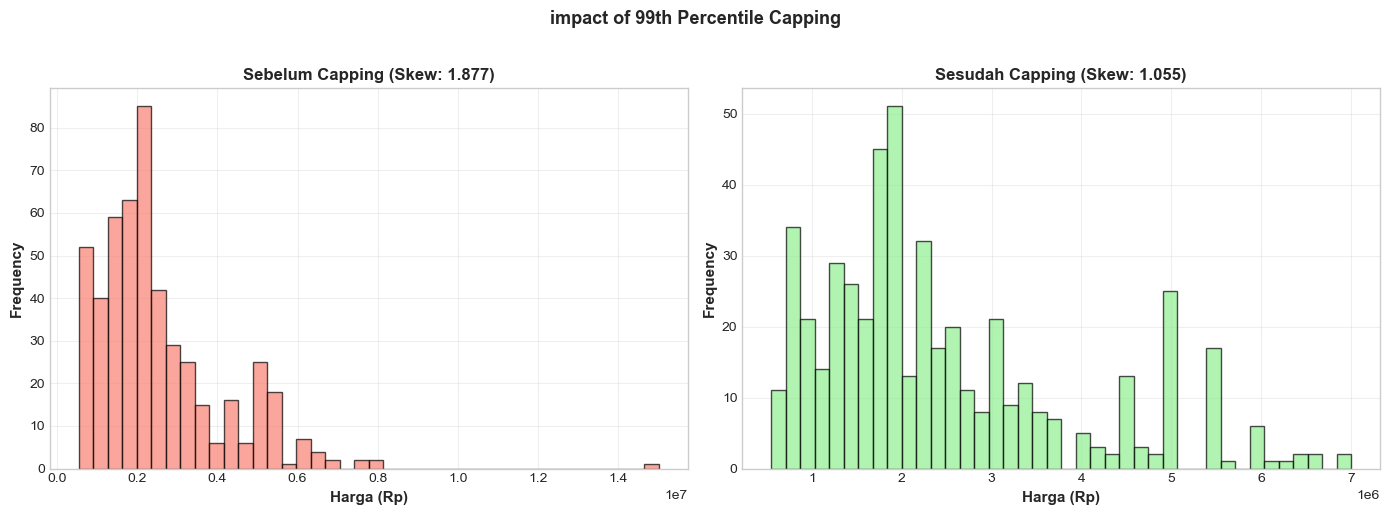

In [13]:
# 3: visualisasi perbandingan distribusi sebelum-sesudah
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sebelum capping
axes[0].hist(df_clean['harga'], bins=40, color='salmon', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title(f'Sebelum Capping (Skew: {skewness_before:.3f})', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Sesudah capping
axes[1].hist(df_final['harga'], bins=40, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title(f'Sesudah Capping (Skew: {skewness_after:.3f})', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.suptitle('impact of 99th Percentile Capping', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Penerapan capping pada 99th percentile berhasil mengurangi tingkat skewness distribusi harga dari 1.877 menjadi 1.055, yang menunjukkan distribusi menjadi lebih seimbang tanpa menghilangkan karakteristik utama pasar. Visualisasi setelah capping memperlihatkan berkurangnya pengaruh harga ekstrem, sementara pola distribusi harga mayoritas tetap terjaga.

Langkah ini bertujuan untuk meningkatkan stabilitas pelatihan model dan mengurangi bias akibat nilai ekstrem, tanpa melakukan penghapusan data secara agresif. Hasil ini menjadi dasar yang lebih sehat untuk melanjutkan ke tahap preprocessing dan pemodelan.

### Data Cleaning Summary

**Penghapusan Fitur Konstan**  
- **Fitur dihapus:** `is_ac`, `is_internet`  
- **Alasan:** Kedua fitur memiliki **nilai konstan (variance = 0)** sehingga tidak memberikan informasi diskriminatif terhadap target (`harga`).  
- **Dampak:** Jumlah kolom berkurang dari **13 menjadi 11**, tanpa kehilangan informasi yang relevan.

**Penanganan Outlier Harga (99th Percentile Capping)**  
- **Batas capping:** Rp **7.005.000**  
- **Jumlah baris sebelum capping:** 500  
- **Jumlah baris setelah capping:** 495  
- **Baris dihapus:** 5 (**1.00%**)

**Dampak terhadap Distribusi Target**  
- **Skewness sebelum:** 1.8771  
- **Skewness sesudah:** 1.0550  
- **Perbaikan:** **43.8%** penurunan skewness

---

## SECTION 4: Feature Engineering & Selection

**Objective:**
- Buat fitur turunan yang memiliki potensi berefek kuat: proximity_score dan is_walking_dist
- Validasi dampak fitur baru terhadap target variable
- Lakukan feature selection untuk menghapus fitur redundan
- Fokus pada fitur yang paling informatif untuk prediksi harga

**Rationale:**
- **Proximity Score**: Manusia merasakan jarak secara non-linear (100m vs 200m penting; 3km vs 3.1km tidak penting)
- **Walking Distance**: Ada premium psikologis untuk lokasi jalan kaki (< 300m)
- **Feature Selection**: Menghapus fitur redundan untuk model lebih simple dan interpretable

Reference:
1.	Walking Distance Flag Distance https://www.researchgate.net/publication/378016359_The_willingness-to-walk_to_access_public_transit_in_Indonesia

In [14]:
# Feature Engineering

# 1. Proximity Score (Inverse Distance)
# Formula: 1 / (Jarak + 0.1)
# Logika: Semakin dekat, skor semakin tinggi, exponentially
# Constant 0.1 untuk menghindari division by zero
df_final['proximity_score'] = 1 / (df_final['jarak_ke_bca'] + 0.1)

# 2. Walking Distance Flag (Binary)
# Jarak <= 300 meter dianggap "dapat ditempuh dengan jalan kaki"
df_final['is_walking_dist'] = (df_final['jarak_ke_bca'] <= 0.3).astype(int)

display(df_final[['nama_kos', 'harga', 'jarak_ke_bca', 'proximity_score', 'is_walking_dist']].head(8))

,nama_kos,harga,jarak_ke_bca,proximity_score,is_walking_dist
0,Kost Cikini Cozy Coliving Exclusive Hoek Mente...,4500000,2.22,0.43,0
1,Kost Singgahsini Cut Nyak Dien Residence Tipe ...,3025000,1.50,0.62,0
2,Kost Singgahsini Shankee Sudirman Tipe B Setia...,4525000,1.84,0.52,0
3,Kost Apik Perintis 5 Karet Kuningan Tipe D Set...,1155000,1.86,0.51,0
4,Kost Singgahsini Kramat Kwitang 30 Tipe B Sene...,1495000,2.27,0.42,0
5,Kost Singgahsini Sofia Thamrin Tipe B Tanah Ab...,2925000,1.25,0.74,0
6,Kost Apik Kebon Kacang Tipe B Tanah Abang Jaka...,1725000,0.88,1.02,0
7,Kost Apik Aipda Petamburan Tipe D Tanah Abang ...,1100000,1.90,0.50,0


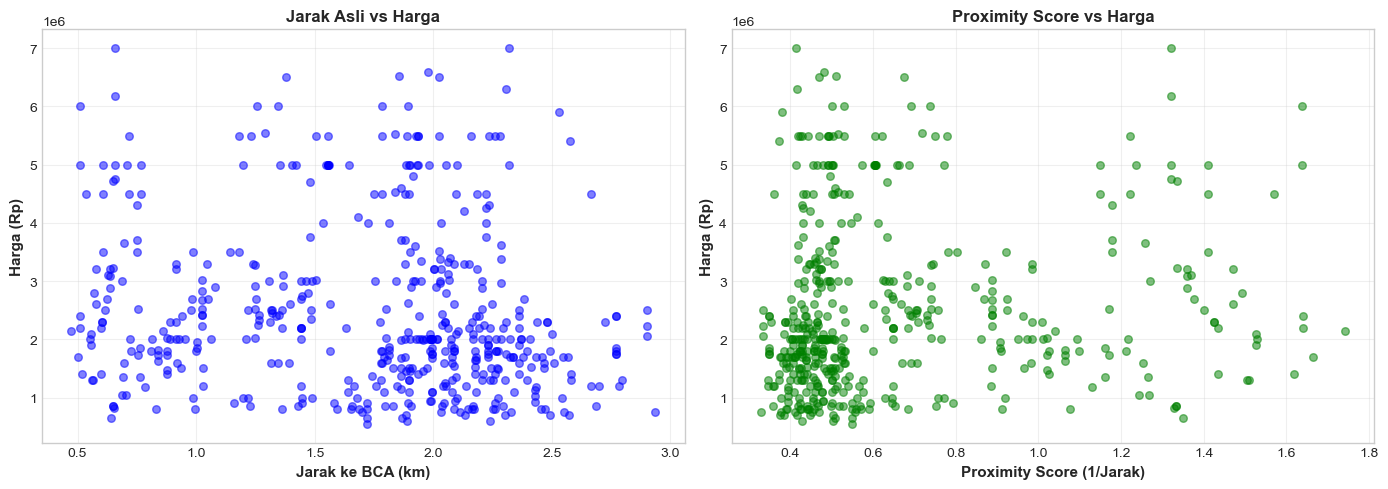

In [15]:
# Visualisasi fitur engineering untuk validasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Jarak asli vs Harga
axes[0].scatter(df_final['jarak_ke_bca'], df_final['harga'], alpha=0.5, s=30, color='blue')
axes[0].set_xlabel('Jarak ke BCA (km)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[0].set_title('Jarak Asli vs Harga', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Proximity Score vs Harga
axes[1].scatter(df_final['proximity_score'], df_final['harga'], alpha=0.5, s=30, color='green')
axes[1].set_xlabel('Proximity Score (1/Jarak)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[1].set_title('Proximity Score vs Harga', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Korelasi dengan TARGET (harga):
harga              1.00
is_water_heater    0.66
is_km_dalam        0.55
is_parkir_mobil    0.48
luas_kamar         0.44
is_mesin_cuci      0.36
proximity_score    0.12
is_furnished      -0.01
jarak_ke_bca      -0.15
is_listrik_free   -0.18
is_walking_dist     NaN
Name: harga, dtype: float64


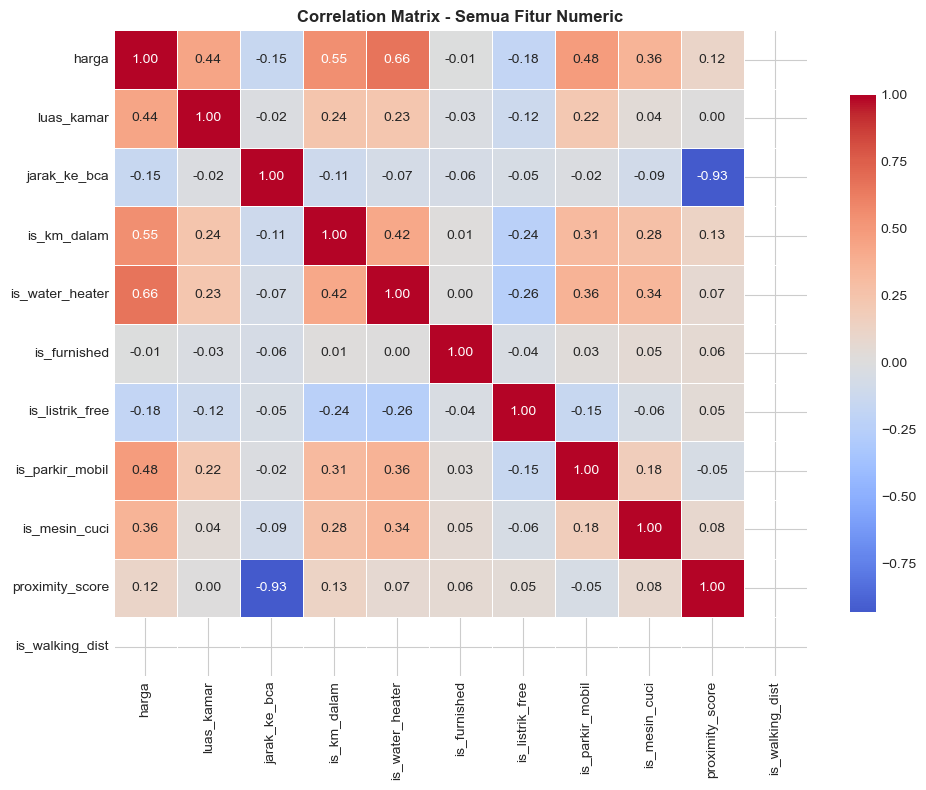

In [16]:
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df_final[numeric_cols].corr()

print("Korelasi dengan TARGET (harga):")
corr_with_target = corr_matrix['harga'].sort_values(ascending=False)
print(corr_with_target)

# Visualisasi correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Semua Fitur Numeric', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

jarak_ke_bca dan proximity_score, keduanya memiliki korelasi yang relatif lemah terhadap variabel target `harga`, sehingga tidak ada indikasi kuat bahwa salah satu memberikan informasi tambahan yang signifikan dibandingkan yang lain.

Dengan mempertimbangkan:
- **Redundansi informasi** antar fitur,
- **Risiko multikolinearitas** jika keduanya digunakan bersamaan,
- **Interpretabilitas yang lebih baik** (satuan kilometer mudah dipahami),
- **Stabilitas numerik** dan konsistensi lintas model,

maka diputuskan untuk **mempertahankan fitur `jarak_ke_bca`** dan **tidak menggunakan `proximity_score`** pada tahap pemodelan.

In [17]:
# Feature selection: drop non-informative features
features_to_drop = ['proximity_score', 'is_walking_dist']

for feat in features_to_drop:
    if feat in corr_with_target.index:
        corr_val = corr_with_target[feat]
        print(f"{feat} (correlation: {corr_val:.4f})")

features_to_drop = [f for f in features_to_drop if f in df_final.columns]
if features_to_drop:
    df_final = df_final.drop(columns=features_to_drop)

df_final['luas_kamar'] = df_final['luas_kamar'].clip(lower=1)

df_final['amenities_count'] = (
    df_final['is_furnished'].astype(int) +
    df_final['is_water_heater'].astype(int) +
    df_final['is_km_dalam'].astype(int) +
    df_final['is_listrik_free'].astype(int) +
    df_final['is_mesin_cuci'].astype(int) +
    df_final['is_parkir_mobil'].astype(int)
)

print(f"\nFeatures added:")
print(f"  amenities_count: Total amenities available (0-6 range)")
print(f"\nFinal dataset: {df_final.shape}")
print(f"Features: {[c for c in df_final.columns if c not in ['nama_kos', 'harga']]}")

proximity_score (correlation: 0.1164)
is_walking_dist (correlation: nan)

Features added:
  amenities_count: Total amenities available (0-6 range)

Final dataset: (495, 12)
Features: ['luas_kamar', 'jarak_ke_bca', 'tipe_kos', 'is_km_dalam', 'is_water_heater', 'is_furnished', 'is_listrik_free', 'is_parkir_mobil', 'is_mesin_cuci', 'amenities_count']


---

## SECTION 5: Train-Test Split dengan Stratification

**Objective:**
- Implementasi stratified split untuk memastikan train & test set representatif
- Test multiple random seeds untuk menemukan split paling balanced
- Gunakan composite scoring: range_diff + mean_diff + std_diff
- Dokumentasi best_split selection criteria

In [18]:
df_final['price_segment'] = pd.cut(
    df_final['harga'],
    bins=[0, 1_500_000, 3_500_000, 6_000_000, 100_000_000],
    labels=['Budget', 'Standard', 'Upper-Standard', 'Premium'],
    duplicates='drop'
)

X = df_final.drop(columns=['nama_kos', 'harga', 'price_segment'])
y = df_final['harga'].copy()

print(f"Total samples: {len(df_final)}")
print(f"Features: {X.shape[1]}")
print(f"Feature names: {list(X.columns)}")

# Statistik full dataset untuk comparison
full_range = y.max() - y.min()
full_mean = y.mean()
full_std = y.std()

print(f"\nFull Dataset Statistics:")
print(f"  Range: Rp {full_range:,.0f}")
print(f"  Mean: Rp {full_mean:,.0f}")
print(f"  Std Dev: Rp {full_std:,.0f}")

Total samples: 495
Features: 10
Feature names: ['luas_kamar', 'jarak_ke_bca', 'tipe_kos', 'is_km_dalam', 'is_water_heater', 'is_furnished', 'is_listrik_free', 'is_parkir_mobil', 'is_mesin_cuci', 'amenities_count']

Full Dataset Statistics:
  Range: Rp 6,450,000
  Mean: Rp 2,472,747
  Std Dev: Rp 1,430,627


In [19]:
# Test multiple random seeds untuk menemukan split terbaik
from sklearn.model_selection import train_test_split

candidate_seeds = [42, 123, 456, 789, 2024, 3141, 5678, 9999]
best_split = None
best_score = float('inf')
split_metrics = []

print(f"\n{'Seed':<6} | {'Range (Rp)':<15} | {'Mean (Rp)':<15} | {'Std (Rp)':<15} | {'Score':<8}")

for seed in candidate_seeds:
    X_temp, X_test_cand, y_temp, y_test_cand = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=df_final['price_segment']
    )
    
    test_range = y_test_cand.max() - y_test_cand.min()
    test_mean = y_test_cand.mean()
    test_std = y_test_cand.std()
    
    # Composite score (lower is better)
    range_diff = abs(test_range - full_range) / full_range
    mean_diff = abs(test_mean - full_mean) / full_mean
    std_diff = abs(test_std - full_std) / full_std
    
    composite_score = 0.5 * range_diff + 0.3 * mean_diff + 0.2 * std_diff
    
    split_metrics.append({
        'seed': seed,
        'test_range': test_range,
        'test_mean': test_mean,
        'test_std': test_std,
        'range_diff': range_diff,
        'mean_diff': mean_diff,
        'std_diff': std_diff,
        'composite_score': composite_score
    })
    
    if composite_score < best_score:
        best_score = composite_score
        best_split = seed
    
    print(f"{seed:<6} | Rp {test_range/1e6:<13.2f}M | Rp {test_mean/1e6:<13.2f}M | Rp {test_std/1e6:<13.2f}M | {composite_score:<8.4f}")

print(f"BEST SPLIT: random_state = {best_split} (score: {best_score:.4f})")


Seed   | Range (Rp)      | Mean (Rp)       | Std (Rp)        | Score   
42     | Rp 6.35         M | Rp 2.50         M | Rp 1.46         M | 0.0147  
123    | Rp 6.40         M | Rp 2.47         M | Rp 1.48         M | 0.0105  
456    | Rp 5.90         M | Rp 2.49         M | Rp 1.44         M | 0.0464  
789    | Rp 6.35         M | Rp 2.51         M | Rp 1.51         M | 0.0223  
2024   | Rp 5.82         M | Rp 2.49         M | Rp 1.46         M | 0.0547  
3141   | Rp 5.77         M | Rp 2.49         M | Rp 1.53         M | 0.0686  
5678   | Rp 6.40         M | Rp 2.41         M | Rp 1.46         M | 0.0147  
9999   | Rp 6.40         M | Rp 2.49         M | Rp 1.46         M | 0.0104  
BEST SPLIT: random_state = 9999 (score: 0.0104)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=best_split, stratify=df_final['price_segment']
)

print(f"\nTrain Set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Mean: Rp {y_train.mean():,.0f}")
print(f"  - Std:  Rp {y_train.std():,.0f}")
print(f"  - Min:  Rp {y_train.min():,.0f}")
print(f"  - Max:  Rp {y_train.max():,.0f}")

print(f"\nTest Set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  - Mean: Rp {y_test.mean():,.0f}")
print(f"  - Std:  Rp {y_test.std():,.0f}")
print(f"  - Min:  Rp {y_test.min():,.0f}")
print(f"  - Max:  Rp {y_test.max():,.0f}")

print(f"\nFeatures: {list(X_train.columns)}")


Train Set: 396 samples (80.0%)
  - Mean: Rp 2,468,383
  - Std:  Rp 1,424,520
  - Min:  Rp 550,000
  - Max:  Rp 7,000,000

Test Set: 99 samples (20.0%)
  - Mean: Rp 2,490,202
  - Std:  Rp 1,462,008
  - Min:  Rp 600,000
  - Max:  Rp 7,000,000

Features: ['luas_kamar', 'jarak_ke_bca', 'tipe_kos', 'is_km_dalam', 'is_water_heater', 'is_furnished', 'is_listrik_free', 'is_parkir_mobil', 'is_mesin_cuci', 'amenities_count']


---

## SECTION 6: Model Pipeline Architecture

**Objective:**
  1. **CONTINUOUS features** → RobustScaler (outlier-resistant)
  2. **BINARY features** → Passthrough (preserve 0/1 semantics)
  3. **CATEGORICAL features** → OneHotEncoder (nominal expansion)
- Ensure semantic correctness & interpretability di setiap tier
- Build end-to-end pipeline untuk konsistensi train-test dengan nama features yang preserved

- **RobustScaler** (Continuous): Robust terhadap outlier menggunakan median & IQR
  - Formula: X_scaled = (X - median) / IQR
- **Passthrough** (Binary): Tidak di-scale; biarkan as-is 0/1 untuk tree-based models
- **OneHotEncoder** (Categorical): Expand ke dummy variables, handle unknown categories safely

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

continuous_cols_linear = ['jarak_ke_bca', 'luas_kamar']

binary_cols = ['is_furnished', 'is_water_heater', 'is_km_dalam', 
               'is_listrik_free', 'is_mesin_cuci', 'is_parkir_mobil']

categorical_cols = ['tipe_kos']

continuous_cols_tree = continuous_cols_linear + ['amenities_count']

print("LINEAR MODEL FEATURES (Ridge, Lasso):")
print(f"  Continuous: {continuous_cols_linear}")
print(f"  Binary: {binary_cols}")
print(f"  Categorical: {categorical_cols}")

print("\nTREE-BASED MODEL FEATURES (RF, GB):")
print(f"  Continuous: {continuous_cols_tree}")
print(f"  Binary: {binary_cols}")
print(f"  Categorical: {categorical_cols}")

preprocessor_linear = ColumnTransformer([
    ('continuous', RobustScaler(), continuous_cols_linear),
    ('binary', 'passthrough', binary_cols),
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
], remainder='drop', verbose=0)

preprocessor_tree = ColumnTransformer([
    ('continuous', RobustScaler(), continuous_cols_tree),
    ('binary', 'passthrough', binary_cols),
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
], remainder='drop', verbose=0)

LINEAR MODEL FEATURES (Ridge, Lasso):
  Continuous: ['jarak_ke_bca', 'luas_kamar']
  Binary: ['is_furnished', 'is_water_heater', 'is_km_dalam', 'is_listrik_free', 'is_mesin_cuci', 'is_parkir_mobil']
  Categorical: ['tipe_kos']

TREE-BASED MODEL FEATURES (RF, GB):
  Continuous: ['jarak_ke_bca', 'luas_kamar', 'amenities_count']
  Binary: ['is_furnished', 'is_water_heater', 'is_km_dalam', 'is_listrik_free', 'is_mesin_cuci', 'is_parkir_mobil']
  Categorical: ['tipe_kos']


---

## SECTION 7: Baseline Model Comparison

**Objective:**
- Train 5 baseline models tanpa hyperparameter tuning
- Model: Linear Regression, Ridge, Lasso, Random Forest, Gradient Boosting
- Evaluasi dengan MAE & R²
- Identifikasi best baseline untuk tuning

**Models to Compare:**
1. **Linear Regression**: Baseline linear, simple
2. **Ridge**: Linear dengan L2 regularization
3. **Lasso**: Linear dengan L1 regularization
4. **Random Forest**: Ensemble bagging, robust to nonlinearity
5. **Gradient Boosting**: Ensemble boosting, iterative error correction

In [22]:
X_train_processed_linear = preprocessor_linear.fit_transform(X_train)
X_test_processed_linear = preprocessor_linear.transform(X_test)

X_train_processed_tree = preprocessor_tree.fit_transform(X_train)
X_test_processed_tree = preprocessor_tree.transform(X_test)

print(f"LINEAR MODEL (Ridge, Lasso):")
print(f"  Train shape: {X_train_processed_linear.shape}")
print(f"  Test shape: {X_test_processed_linear.shape}")

print(f"\nTREE-BASED MODELS (RF, GB - Strategy C):")
print(f"  Train shape: {X_train_processed_tree.shape}")
print(f"  Test shape: {X_test_processed_tree.shape}")

LINEAR MODEL (Ridge, Lasso):
  Train shape: (396, 11)
  Test shape: (99, 11)

TREE-BASED MODELS (RF, GB - Strategy C):
  Train shape: (396, 12)
  Test shape: (99, 12)


In [23]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

linear_models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=5000),
}

tree_models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=15, random_state=RANDOM_SEED, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=RANDOM_SEED),
}

results_linear = []
results_tree = []

print("LINEAR MODELS:")
print(f"{'Model':<30} MAE               R²")

for name, model in linear_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor_linear),
        ('regressor', model)
    ])
    
    try:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        results_linear.append({
            'Model': name,
            'MAE': mae,
            'R2': r2,
            'RMSE': rmse,
            'MAPE': mape,
            'Pipeline': pipeline
        })
        
        print(f"{name:<30} Rp {mae:>12,.0f}    {r2:>8.4f}")
        
    except Exception as e:
        print(f"{name:<30} ERROR: {str(e)[:50]}")

print("TREE-BASED MODELS:")
print(f"{'Model':<30} MAE               R²")

for name, model in tree_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor_tree),
        ('regressor', model)
    ])
    
    try:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        results_tree.append({
            'Model': name,
            'MAE': mae,
            'R2': r2,
            'RMSE': rmse,
            'MAPE': mape,
            'Pipeline': pipeline
        })
        
        print(f"{name:<30} Rp {mae:>12,.0f}    {r2:>8.4f}")
        
    except Exception as e:
        print(f"{name:<30} ERROR: {str(e)[:50]}")

all_results = results_linear + results_tree

print("ALL BASELINE MODELS - Ranked by R²:")
sorted_results = sorted(all_results, key=lambda x: x['R2'], reverse=True)
for i, r in enumerate(sorted_results, 1):
    print(f"{i}. {r['Model']:<28} R² = {r['R2']}  MAE = Rp {r['MAE']:>11,.0f}  MAPE = {r['MAPE']:>5.1f}%")


LINEAR MODELS:
Model                          MAE               R²
Linear Regression              Rp      620,120      0.6529
Ridge                          Rp      619,180      0.6538
Lasso                          Rp      620,120      0.6529
TREE-BASED MODELS:
Model                          MAE               R²
Random Forest                  Rp      544,303      0.6913
Gradient Boosting              Rp      521,875      0.7177
ALL BASELINE MODELS - Ranked by R²:
1. Gradient Boosting            R² = 0.7177048871267842  MAE = Rp     521,875  MAPE =  24.9%
2. Random Forest                R² = 0.6913068613341394  MAE = Rp     544,303  MAPE =  26.6%
3. Ridge                        R² = 0.6537506538140394  MAE = Rp     619,180  MAPE =  28.7%
4. Lasso                        R² = 0.6529286070357934  MAE = Rp     620,120  MAPE =  28.7%
5. Linear Regression            R² = 0.6529285979264206  MAE = Rp     620,120  MAPE =  28.7%


### Baseline Model Interpretation

Hasil evaluasi baseline menunjukkan bahwa model non-linear berbasis pohon (Random Forest dan Gradient Boosting) memberikan performa yang lebih baik dibandingkan model linear (Linear Regression, Ridge, dan Lasso) pada data Jakarta Pusat.

Model Gradient Boosting menghasilkan performa terbaik dengan nilai MAE terendah dan R² tertinggi, diikuti oleh Random Forest. Hal ini mengindikasikan bahwa hubungan antara fitur-fitur properti dan harga kos di Jakarta Pusat tidak sepenuhnya linear, serta terdapat interaksi non-linear antar fitur yang dapat ditangkap dengan lebih baik oleh model berbasis pohon.

Meskipun model linear menunjukkan performa yang relatif stabil dan konsisten (dengan nilai R² sekitar 0.65), keterbatasannya dalam menangkap pola non-linear membuatnya kurang optimal dibandingkan model tree-based pada tahap baseline ini. Regularisasi pada Ridge tidak memberikan peningkatan signifikan dibandingkan Linear Regression, yang mengindikasikan bahwa kompleksitas tambahan pada model linear tidak cukup untuk menangkap variasi harga secara lebih mendalam.

Berdasarkan hasil ini, model tree-based dipertimbangkan lebih lanjut pada tahap tuning untuk mengevaluasi potensi peningkatan performa sekaligus memastikan bahwa kompleksitas model tidak menyebabkan overfitting.

---

## SECTION 8 & 9 & 10: Hyperparameter Tuning, Model Selection, & Evaluation

**Key Steps:**
1. RandomizedSearchCV dengan gap-aware selection
2. Tune Random Forest & Gradient Boosting
3. Final model selection
4. Residual analysis
5. Feature importance
6. Production deployment

In [24]:
from sklearn.model_selection import GridSearchCV

ridge_alphas = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

param_grid = {
    'regressor__alpha': ridge_alphas
}

ridge_search = GridSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor_linear),
        ('regressor', Ridge(random_state=RANDOM_SEED))
    ]),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

ridge_search.fit(X_train, y_train)

final_ridge_pipeline = ridge_search.best_estimator_

**Ridge Regression - GridSearchCV**:
- Ridge has **1 hyperparameter** (alpha) with **7 discrete values** to evaluate
- GridSearchCV exhaustively tests ALL 7 combinations: 7 × 5-fold CV = 35 model fits
- Comprehensive search suitable for small, well-defined parameter space
- Low computational cost (fast)

**Random Forest & Gradient Boosting - RandomizedSearchCV**:
- RF/GB have **15+ hyperparameters** with essentially infinite combinations
- RandomizedSearchCV samples 50 random combinations: 50 × 5-fold CV = 250 model fits
- Efficient sampling necessary for high-dimensional parameter space
- Provides good coverage without exhaustive search

In [25]:
best_ridge_alpha = ridge_search.best_params_['regressor__alpha']
best_ridge_mae = -ridge_search.best_score_ 

print(f"Best alpha found: {best_ridge_alpha}")
print(f"Best cross-val MAE: Rp {best_ridge_mae:,.0f}")

Best alpha found: 2.0
Best cross-val MAE: Rp 637,830


In [26]:
final_ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor_linear),
    ('regressor', Ridge(alpha=best_ridge_alpha, random_state=RANDOM_SEED))
])

final_ridge_pipeline.fit(X_train, y_train)

print(f"FINAL RIDGE MODEL (alpha={best_ridge_alpha})")
y_ridge_pred = final_ridge_pipeline.predict(X_test)
ridge_mae = mean_absolute_error(y_test, y_ridge_pred)
ridge_r2 = r2_score(y_test, y_ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_ridge_pred))
final_mape = np.mean(np.abs((y_test - y_ridge_pred) / y_test)) * 100

print(f"Test Set Performance:")
print(f"  MAE: Rp {ridge_mae:,.0f}")
print(f"  RMSE: Rp {ridge_rmse:,.0f}")
print(f"  R²: {ridge_r2:.4f}")
print(f"  MAPE: {final_mape:.2f}%")

FINAL RIDGE MODEL (alpha=2.0)
Test Set Performance:
  MAE: Rp 618,344
  RMSE: Rp 855,016
  R²: 0.6545
  MAPE: 28.69%


In [27]:
lasso_alphas = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]

lasso_param_grid = {
    'regressor__alpha': lasso_alphas
}

lasso_search = GridSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor_linear),
        ('regressor', Lasso(max_iter=5000, random_state=RANDOM_SEED))
    ]),
    param_grid=lasso_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

lasso_search.fit(X_train, y_train)

best_lasso_alpha = lasso_search.best_params_['regressor__alpha']
best_lasso_mae = -lasso_search.best_score_

print(f"Best alpha found: {best_lasso_alpha}")
print(f"Best cross-val MAE: Rp {best_lasso_mae:,.0f}")

final_lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor_linear),
    ('regressor', Lasso(alpha=best_lasso_alpha, max_iter=5000, random_state=RANDOM_SEED))
])

final_lasso_pipeline.fit(X_train, y_train)

y_lasso_pred = final_lasso_pipeline.predict(X_test)
lasso_mae = mean_absolute_error(y_test, y_lasso_pred)
lasso_r2 = r2_score(y_test, y_lasso_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_lasso_pred))
lasso_mape = np.mean(np.abs((y_test - y_lasso_pred) / y_test)) * 100

print(f"\nTest Set Performance:")
print(f"  MAE: Rp {lasso_mae:,.0f}")
print(f"  R²: {lasso_r2:.4f}")
print(f"  RMSE: Rp {lasso_rmse:,.0f}")
print(f"  MAPE: {lasso_mape:.2f}%")

Best alpha found: 0.001
Best cross-val MAE: Rp 638,229

Test Set Performance:
  MAE: Rp 620,120
  R²: 0.6529
  RMSE: Rp 856,948
  MAPE: 28.73%


In [28]:
def auto_tune_healthy(pipeline, param_dist, X_train, y_train, gap_threshold=0.10, n_iter=50):
    from sklearn.model_selection import RandomizedSearchCV
    
    rs = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=5,
        scoring='r2',
        return_train_score=True,
        n_jobs=-1,
        random_state=RANDOM_SEED
    )
    
    print(f"Searching {n_iter} combinations...")
    rs.fit(X_train, y_train)
    
    results_df = pd.DataFrame(rs.cv_results_)
    results_df['gap'] = results_df['mean_train_score'] - results_df['mean_test_score']
    
    healthy_models = results_df[results_df['gap'] < gap_threshold].copy()
    
    if not healthy_models.empty:
        best_idx = healthy_models['mean_test_score'].idxmax()
        best_params = healthy_models.loc[best_idx, 'params']
        best_score = healthy_models.loc[best_idx, 'mean_test_score']
        best_gap = healthy_models.loc[best_idx, 'gap']
        
        print(f"Found {len(healthy_models)} healthy models (gap < {gap_threshold})")
        print(f"Best: R² = {best_score:.4f}, Gap = {best_gap:.4f}")
        
        pipeline.set_params(**best_params)
        pipeline.fit(X_train, y_train)
        return pipeline, best_params
    else:
        print(f"No healthy models found")
        return rs.best_estimator_, rs.best_params_

In [29]:
print("Random Forest Tuning")

param_dist_rf = {
    'regressor__max_depth': [5, 8, 10, 12, 15, 20],
    'regressor__n_estimators': [150, 200, 250],
    'regressor__min_samples_leaf': [2, 4, 8],
    'regressor__max_features': ['sqrt', 'log2']
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('regressor', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1))
])

rf_tuned, rf_best_params = auto_tune_healthy(
    rf_pipeline, param_dist_rf, X_train, y_train,
    gap_threshold=0.10, n_iter=100
)

print(f"Best Parameters Found: {rf_best_params}")

y_pred_rf = rf_tuned.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print(f"\nTest Set - MAE: Rp {mae_rf:,.0f}, R²: {r2_rf:.4f}, RMSE: Rp {rmse_rf:,.0f}, MAPE: {mape_rf:.2f}%")

Random Forest Tuning
Searching 100 combinations...
Found 38 healthy models (gap < 0.1)
Best: R² = 0.6554, Gap = 0.0915
Best Parameters Found: {'regressor__n_estimators': 250, 'regressor__min_samples_leaf': 4, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 5}

Test Set - MAE: Rp 537,550, R²: 0.7119, RMSE: Rp 780,802, MAPE: 27.45%


In [30]:
print("Gradient Boosting Tuning")

param_dist_gb = {
    'regressor__max_depth': [2, 3, 4, 5, 6],
    'regressor__n_estimators': [100, 150, 200, 250],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.15],
    'regressor__subsample': [0.7, 0.8, 0.9],
    'regressor__min_samples_leaf': [2, 4, 8]
}

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('regressor', GradientBoostingRegressor(random_state=RANDOM_SEED))
])

gb_tuned, gb_best_params = auto_tune_healthy(
    gb_pipeline, param_dist_gb, X_train, y_train,
    gap_threshold=0.10, n_iter=100
)

print(f"Best Parameters Found: {gb_best_params}")

y_pred_gb = gb_tuned.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mape_gb = np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100

print(f"\nTest Set - MAE: Rp {mae_gb:,.0f}, R²: {r2_gb:.4f}, RMSE: Rp {rmse_gb:,.0f}, MAPE: {mape_gb:.2f}%")

Gradient Boosting Tuning
Searching 100 combinations...
Found 12 healthy models (gap < 0.1)
Best: R² = 0.6476, Gap = 0.0997
Best Parameters Found: {'regressor__subsample': 0.7, 'regressor__n_estimators': 200, 'regressor__min_samples_leaf': 4, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.01}

Test Set - MAE: Rp 561,368, R²: 0.6897, RMSE: Rp 810,281, MAPE: 29.26%


In [31]:
final_model = rf_tuned

y_pred_test = final_model.predict(X_test)

final_r2 = r2_score(y_test, y_pred_test)
final_mae = mean_absolute_error(y_test, y_pred_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
final_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"  R²: {final_r2}")
print(f"  MAE: Rp {final_mae:,.0f}")
print(f"  RMSE: Rp {final_rmse:,.0f}")
print(f"  MAPE: {final_mape:.2f}%")

  R²: 0.7118680829733509
  MAE: Rp 537,550
  RMSE: Rp 780,802
  MAPE: 27.45%


In [32]:
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

y_train_pred = final_model.predict(X_train)
y_test_pred  = final_model.predict(X_test)

train_r2  = r2_score(y_train, y_train_pred)
test_r2   = r2_score(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae  = mean_absolute_error(y_test, y_test_pred)

# Gap
r2_gap  = train_r2 - test_r2
mae_gap = test_mae - train_mae

print(f"{'Metric':<15} {'Train':>12} {'Test':>12} {'Gap':>12}")
print(f"{'R²':<15} {train_r2:>12.4f} {test_r2:>12.4f} {r2_gap:>12.4f}")
print(f"{'MAE':<15} Rp {train_mae:>9,.0f} Rp {test_mae:>9,.0f} Rp {mae_gap:>9,.0f}")

Metric                 Train         Test          Gap
R²                    0.7414       0.7119       0.0295
MAE             Rp   534,767 Rp   537,550 Rp     2,783


In [36]:
import sys
import os
sys.path.append(os.path.abspath('../src/training'))

from utils import train_and_register

params = {
    "model_type": "RandomForestRegressor",
    "regressor__n_estimators": 250,
    "regressor__min_samples_leaf": 4,
    "regressor__max_features": "sqrt",
    "regressor__max_depth": 5
}

metrics = {
    "MAE": final_mae,
    "R2": final_r2,
    "RMSE": final_rmse,
    "MAPE": final_mape
}

model_uri = train_and_register(
    region="jakarta_pusat",
    model=final_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    params=params,
    metrics=metrics
)

print("Model registered at:", model_uri)

2026/02/21 22:47:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model registered at: models:/m-e3e6f0646216404cbadffb4649bf926d


Registered model 'jakarta_pusat_model' already exists. Creating a new version of this model...
Created version '2' of model 'jakarta_pusat_model'.


In [37]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

print("Registered Models:")
print([m.name for m in client.search_registered_models()])

Registered Models:
['jakarta_pusat_model']


In [38]:
# cek alias

client.get_model_version_by_alias("jakarta_pusat_model", "production")

<ModelVersion: aliases=['production'], creation_timestamp=1771688874193, current_stage='None', deployment_job_state=None, description=None, last_updated_timestamp=1771688874193, metrics=None, model_id=None, name='jakarta_pusat_model', params=None, run_id='e7c1bc84be124c75951edbf1d9bddbf9', run_link=None, source='models:/m-e3e6f0646216404cbadffb4649bf926d', status='READY', status_message=None, tags={}, user_id=None, version=2>

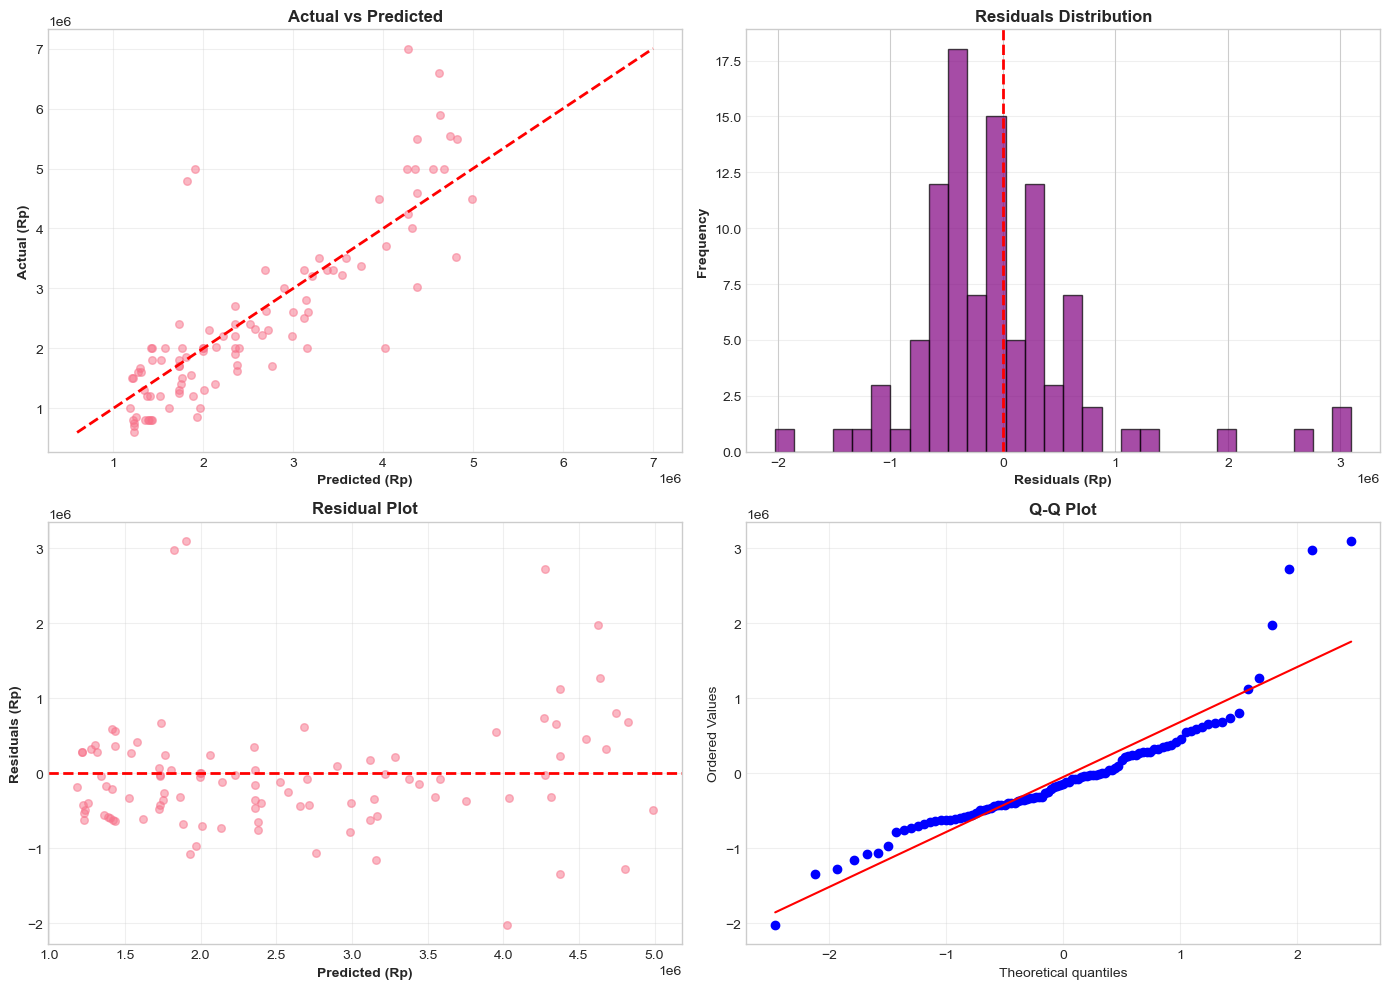


Residuals Statistics:
Mean: Rp -51,153
Std: Rp 783,090
Skewness: 1.655
Kurtosis: 5.370


In [39]:
# Residual Analysis
y_pred_final = final_model.predict(X_test)
residuals = y_test - y_pred_final

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(y_pred_final, y_test, alpha=0.5, s=30)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Predicted (Rp)', fontweight='bold')
axes[0, 0].set_ylabel('Actual (Rp)', fontweight='bold')
axes[0, 0].set_title('Actual vs Predicted', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[0, 1].axvline(0, color='red', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Residuals (Rp)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Residuals Distribution', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

axes[1, 0].scatter(y_pred_final, residuals, alpha=0.5, s=30)
axes[1, 0].axhline(0, color='red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted (Rp)', fontweight='bold')
axes[1, 0].set_ylabel('Residuals (Rp)', fontweight='bold')
axes[1, 0].set_title('Residual Plot', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResiduals Statistics:")
print(f"Mean: Rp {residuals.mean():,.0f}")
print(f"Std: Rp {residuals.std():,.0f}")
print(f"Skewness: {residuals.skew():.3f}")
print(f"Kurtosis: {residuals.kurtosis():.3f}")

Berdasarkan analisis visual Actual vs Predicted, Residual Distribution, Residual Plot, dan Q-Q Plot, model menunjukkan performa prediktif yang stabil dan tidak mengindikasikan overfitting. Error bersifat acak, terpusat di sekitar nol, dan tidak membentuk pola sistematis. Deviasi pada nilai harga ekstrem merupakan karakteristik alami data harga kos dan bukan akibat kegagalan model.

In [40]:
X_test_with_segment = X_test.copy()
X_test_with_segment['price_segment'] = df_final.loc[X_test.index, 'price_segment']

print(f"{'Segment':<20} {'Sample':>10} {'MAE':>15} {'R²':>10} {'MAPE':>10}")

for segment in ['Budget', 'Standard', 'Upper-Standard', 'Premium']:
    mask = X_test_with_segment['price_segment'] == segment
    
    if mask.sum() > 0:
        segment_actual = y_test[mask]
        segment_pred = y_pred_final[mask]
        
        segment_mae = mean_absolute_error(segment_actual, segment_pred)
        segment_r2 = r2_score(segment_actual, segment_pred)
        segment_mape = np.mean(np.abs((segment_actual - segment_pred) / segment_actual)) * 100
        
        print(f"{segment:<20} {mask.sum():>10} Rp {segment_mae:>12,.0f}   {segment_r2:>9.4f}   {segment_mape:>8.2f}%")

Segment                  Sample             MAE         R²       MAPE
Budget                       27 Rp      492,231     -2.9391      51.96%
Standard                     53 Rp      375,589      0.1524      17.51%
Upper-Standard               17 Rp      901,145     -2.7621      18.68%
Premium                       2 Rp    2,350,741   -140.6884      34.44%


---

## Feature Importance & Business Insights

**Objective:**
- Extract dan visualisasi feature importance dari final model
- Berikan interpretasi bisnis untuk setiap top feature
- Validasi insights dengan domain knowledge

Feature Importance

Top Features:
1. is_water_heater: 0.2316
2. amenities_count: 0.1918
3. is_km_dalam: 0.1400
4. tipe_kos_campur: 0.1373
5. luas_kamar: 0.1351


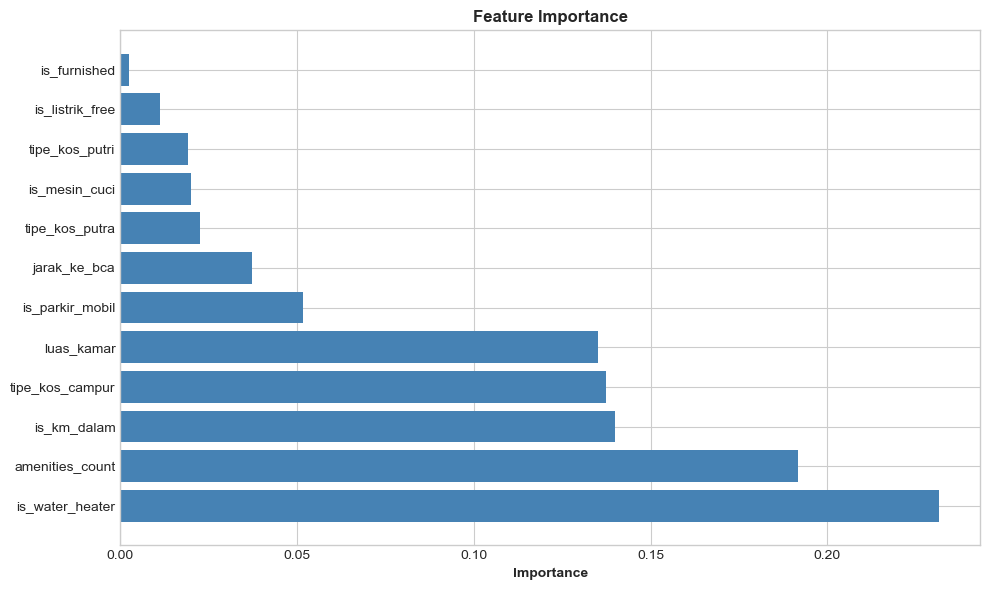

In [41]:
print("Feature Importance")

if hasattr(final_model.named_steps['regressor'], 'feature_importances_'):
    importances = final_model.named_steps['regressor'].feature_importances_
    
    # Get feature names from preprocessor
    preprocessor_obj = final_model.named_steps['preprocessor']
    feature_names_list = []
    
    for name, transformer, columns in preprocessor_obj.transformers_:
        if name == 'continuous':
            feature_names_list.extend(columns)
        elif name == 'binary':
            feature_names_list.extend(columns)
        elif name == 'categorical':
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names_list.extend(transformer.get_feature_names_out(columns))
            else:
                feature_names_list.extend(columns)
    
    indices = np.argsort(importances)[::-1]
    
    print("\nTop Features:")
    for i in range(min(5, len(indices))):
        print(f"{i+1}. {feature_names_list[indices[i]]}: {importances[indices[i]]:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], color='steelblue')
    plt.yticks(range(len(indices)), [feature_names_list[j] for j in indices])
    plt.xlabel('Importance', fontweight='bold')
    plt.title('Feature Importance', fontweight='bold')
    plt.tight_layout()
    plt.show()